## How to restore a DELFI object from a previous run

## Import and create everything exactly as you did before on the previous run, then, when you create the DELFI object, just set "restore=True". It will load in all of the saved attributes of the DELFI object as they were at the end of your previous run, and load in the saved weights of all of the trained NDEs

## In the below example we will imagine you have already run the "jla_sne.ipynb" tutorial notebook, and you want to restore everything without having to re-run from the beginning.

### NOTE: you must have already run the jla_sne.ipynb tutorial through to completion for this notebook to work

## Import your stuff

In [1]:
import numpy as np
import simulators.jla_supernovae.jla_simulator as jla
import ndes as ndes
import delfi as delfi
import score as score
import priors as priors
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

## Set up the simulator
This must have the signature `simulator(parameters, seed, args, batch)` -> `np.array([batch, ndata])`

In [2]:
JLASimulator = jla.JLA_Model()

def simulator(theta, seed, simulator_args, batch):
    
    return JLASimulator.simulation(theta, seed)

simulator_args = None

/Users/justinalsing/Dropbox/science/pydelfi-tf2/pydelfi/examples/simulators/jla_supernovae/jla_parser.py:9: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  dtype = None, names = True)


## Set up the prior

In [3]:
lower = np.array([0, -1.5, -20, 0, 0, -0.5])
upper = np.array([0.6, 0, -18, 1, 6, 0.5])
prior = tfd.Blockwise([tfd.Uniform(low=lower[i], high=upper[i]) for i in range(6)])

## Set up the compressor
Must have the signature `compressor(data, args)` -> `np.array([n_summaries])`<br>
In this case we are going to do Gaussian score compression $$\mathbf{t} = \boldsymbol\theta_* + \mathbf{F}^{-1}\nabla_\theta^T\boldsymbol\mu_*\mathbf{C}^{-1}(\mathbf{d}-\boldsymbol\mu_*)$$ using the class `score.Gaussian`. For this we'll need some fiducial parameters, the mean its derivative at the fiducial parameters, the inverse covariance, and the inverse Fisher matrix

In [4]:
theta_fiducial = np.array([0.2, -0.75, -19.05, 0.125, 2.65, -0.05])

mu = JLASimulator.apparent_magnitude(theta_fiducial)
Cinv = JLASimulator.Cinv

h = np.array(abs(theta_fiducial))*0.01
dmudt = JLASimulator.dmudt(theta_fiducial, h)

Compressor = score.Gaussian(len(JLASimulator.data), theta_fiducial, mu = mu, Cinv = Cinv, dmudt = dmudt)
Compressor.compute_fisher()
Finv = Compressor.Finv

def compressor(d, compressor_args):
    return Compressor.scoreMLE(d)
compressor_args=None

## Load in the compressed data

In [5]:
compressed_data = compressor(JLASimulator.data, compressor_args)

## Define ensemble of NDEs

### These must be defined exactly as you did for the previous run, in this case in jla_sne.ipynb

In [6]:
NDEs = [ndes.ConditionalMaskedAutoregressiveFlow(
            n_parameters=6,
            n_data=6,
            n_mades=5,
            n_hidden=[30,30], 
            activation=tf.keras.layers.LeakyReLU(0.01),
            kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=1e-5, seed=None),
            all_layers=True)]

NDEs += [ndes.MixtureDensityNetwork(
            n_parameters=6,
            n_data=6, 
            n_components=i+1,
            n_hidden=[30], 
            activation=tf.keras.layers.LeakyReLU(0.01))
        for i in range(5)]

NDEs += [ndes.SinhArcSinhMADE(
            n_parameters=6,
            n_data=6,
            n_hidden=[64],
            activation=tf.tanh,
            kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=1e-5, seed=None),
            bias_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=1e-5, seed=None)
        )]

## Create DELFI object

### Do this exactly as we did in jla_sne.ipynb, but with "restore=True"

In [7]:
DelfiEnsemble = delfi.Delfi(compressed_data, prior, NDEs, 
                            Finv=Finv, 
                            theta_fiducial=theta_fiducial, 
                            param_names=['\\Omega_m', 'w_0', 'M_\mathrm{B}', '\\alpha', '\\beta', '\\delta M'], 
                            results_dir="simulators/jla_supernovae/results",
                            filename="jla",
                            optimiser=tf.keras.optimizers.Adam(lr=1e-4),
                            optimiser_arguments=None,
                            dtype=tf.float32,
                            posterior_chain_length=200,
                            nwalkers=500,
                            input_normalization="fisher",
                            restore=True,
                            restore_filename="restore")

## Plot the current posterior approximation (based on the current state of the posterior_samples from the restored DELFI object)

Removed no burn in


/usr/local/lib/python3.7/site-packages/matplotlib/figure.py:2359: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


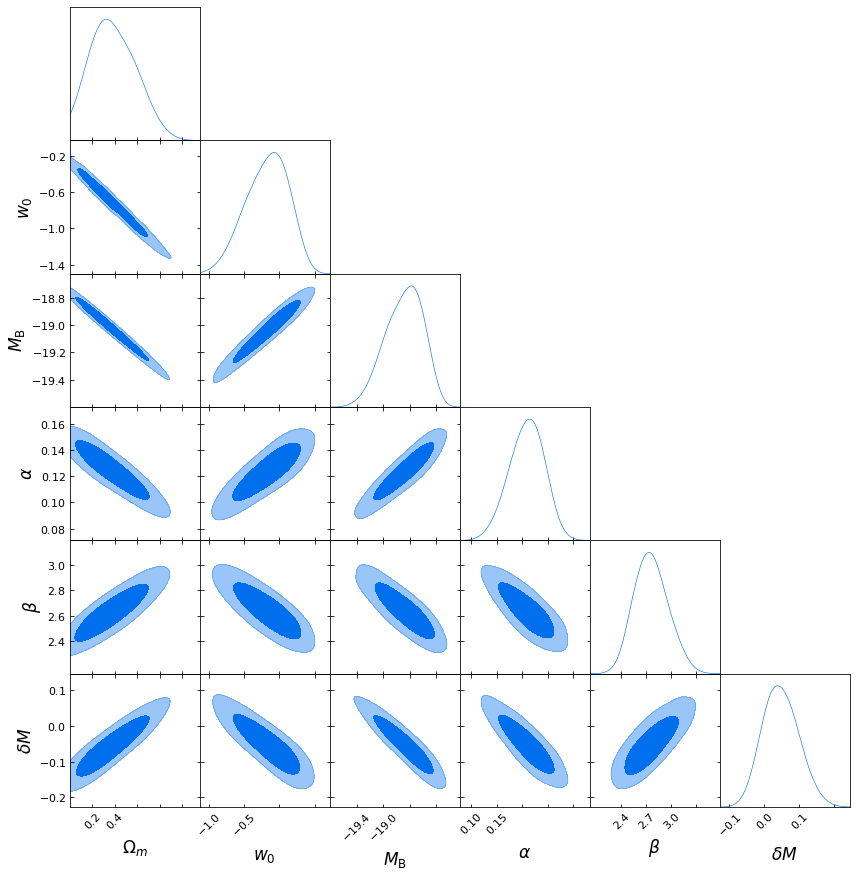

In [10]:
DelfiEnsemble.triangle_plot(samples=[DelfiEnsemble.posterior_samples], weights=[DelfiEnsemble.posterior_weights])